# Pretraining on MNIST
The objective is to pretrain a basic MLP (Multi-Layer Perceptron) in order to create the base corrupted model to later on capture photos from finetuning.

First, all the libraries will be imported:

In [54]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file
import random
import numpy as np


# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed init:

In [55]:
params = {
    'batch_size':1024, #changed from 64 to 256
    'eval_batch_size':64,
    'num_epochs':20,
    'num_classes':10,
    'learning_rate':1e-4,
    'log_interval':300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

The MNIST dataset is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. The Normalization performed is between 0-1, in order to be able to effectively activate the latches for specific datapoints. 

In [56]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=False)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.27 / 0.73


In [57]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([1024, 1, 28, 28])
Batch Label shape:  torch.Size([1024])
The Batched tensors return a collection of 1024 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 1024 batched integers, one per image


(-0.5, 241.5, 3841.5, -0.5)

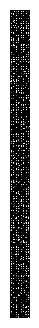

In [58]:
# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img_grid = make_grid(bimg)

plt.figure(figsize = (4, 4))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')

Now the basic MLP is defined, with 3 layers. Keeping in mind that there are 10 classes (10 digits) and the input size is about 28*28 pixels. The image is flattened on the first input, and the decided activation function is ReLu.

In [59]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, params['num_classes'])

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
# Initialize the model, loss function and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [61]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

In [62]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 9 mean training loss: 2.2896
Epoch 9 total training accuracy: 13.56%


(VAL)Epoch 9:  13%|█▎        | 20/157 [00:00<00:00, 195.94it/s]

VAL [1/59], Batch accuracy: 0.977%; Batch Loss: 2.286


(VAL)Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 232.95it/s]


Epoch 9 mean validation loss: 2.2878
Epoch 9 total validation accuracy: 14.34%
EPOCH 10 ------------------------------------


(TRAIN)Epoch 10:   3%|▎         | 2/59 [00:00<00:03, 15.62it/s]

TRAIN [1/59], Batch accuracy: 13.184%; Batch Loss: 2.292


(TRAIN)Epoch 10:  61%|██████    | 36/59 [00:02<00:01, 17.05it/s]


KeyboardInterrupt: 

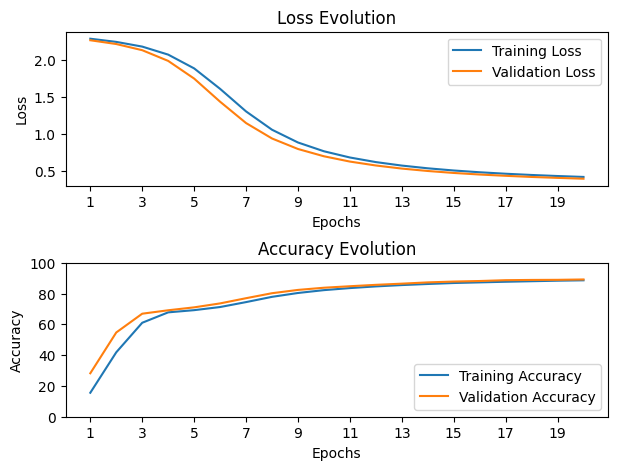

In [40]:
# Graficar la evolución de la pérdida y la precisión
plt.figure(figsize=(7, 5))

plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x


plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.5)

plt.show()

Save results using safetensors

In [41]:
archive_name = "model_pretrained.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

Make some predictions to test results:

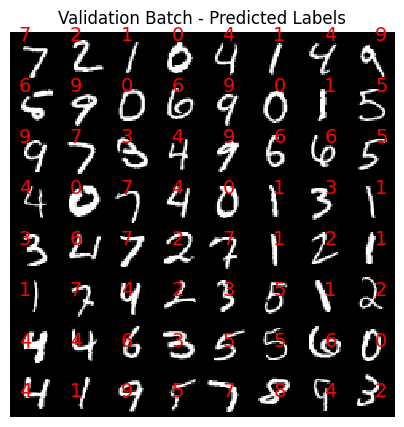

In [44]:
# Set the model to evaluation mode
model.eval()

# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)

# Make predictions
with torch.no_grad():
    val_images = val_images.to(device); val_labels = val_labels.to(device)
    outputs = model(val_images)
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

It can be seen how the model works as thought.